# Cookie Cat A/B testing
![image.png](https://th.bing.com/th/id/R.06e800986f934110df66f51a6822b6ba?rik=fPfT%2bd0H3QlbHg&pid=ImgRaw&r=0)


In [21]:
#Importing Lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
#read data

Cookiecat_df= pd.read_csv('./Cookie_cat_data/cookie_cats.csv')

In [23]:
Cookiecat_df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## A/B-test Data
The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:

- `userid` - a unique number that identifies each player.
version - whether the player was put in the control group (gate_30 - a gate at level 30) or the group with the moved gate (gate_40 - a gate at level 40).
- `sum_gamerounds` - the number of game rounds played by the player during the first 14 days after install.
- `retention_1` - did the player come back and play 1 day after installing?
- `retention_7` - did the player come back and play 7 days after installing?
When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40. As a sanity check, let's see if there are roughly the same number of players in each AB group.

In [24]:
#counting the number of players in each AB group
Cookiecat_df.groupby('version')['userid'].count()

version
gate_30    44700
gate_40    45489
Name: userid, dtype: int64

## The distribution of game rounds
- It appears that each category contains essentially the same number of participants.
- The focus of this analysis will be on how gate placement impacts player retention, but for amusement, let's plot the distribution of the number of game cycles participants played during their first week of playing the game.


Text(0.5, 1.0, 'Histogram of Gamerounds for the First 100 Rows')

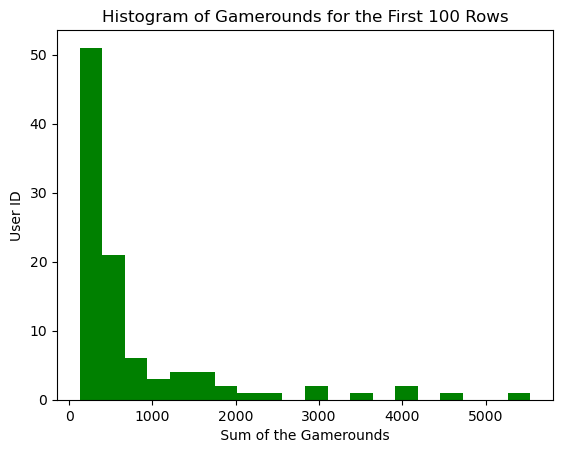

In [25]:
# This command makes plots appear in the notebook
%matplotlib inline

# Counting the number of players for each number of gamerounds 
plot_df = Cookiecat_df.groupby ('sum_gamerounds')['userid'].count()

# Plotting the distribution of players that played 0 to 100 game rounds

ax = plot_df.head(100).plot(kind= 'hist', x='sum_gamerounds', bins=20, color='green',legend=False)
ax.set_xlabel(" Sum of the Gamerounds ")
ax.set_ylabel("User ID")
ax.set_title("Histogram of Gamerounds for the First 100 Rows")

## Overall 1-day retention
- We can see from the plot above that some people download the game but never play it (0 game rounds), other players just play a few game rounds in their first week, and some players get completely fascinated with the game!
- The goal is for players to enjoy the experience and get addicted. The proportion of players that return to play a game one day after installing it is a widely used indicator in the game industry of how entertaining and captivating a game is. The simpler it is to keep players and develop a sizable player base, the greater 1-day retention is.
- Let's start by taking a general look of 1-day retention.

In [26]:
# The % of users that came back the day after they installed
Cookiecat_df['retention_1'].mean()

0.4452095044850259

## 1-day retention by AB-group
One day after downloading the game, a little under half of the gamers return. We may compare the two AB-groups' 1-day retention levels now that we have a baseline.

In [27]:
# The % of users that came back the day after they installed group by version
Cookiecat_df.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

## Should we be confident in the difference?
- When the gate was lowered to level 40 (44.2%) from level 30 (44.8%), it seems that there was a modest reduction in 1-day retention. It's a little adjustment, but retention may be significantly impacted by even minor adjustments. How certain should we be that a gate at level 40 will be worse in the future, even if we are convinced of the difference in the data?

- We can determine the degree of confidence in these retention rates in a few different methods. We'll utilise bootstrapping in this case: Our dataset will be regularly re-sampled (with replacement), and for those samples, 1-day retention will be determined. We can tell how dubious the retention data are by looking at the variance in 1-day retention.

Text(0.5, 1.0, 'Bootstrap Analysis of 1-Day Retention by AB-group (Version)')

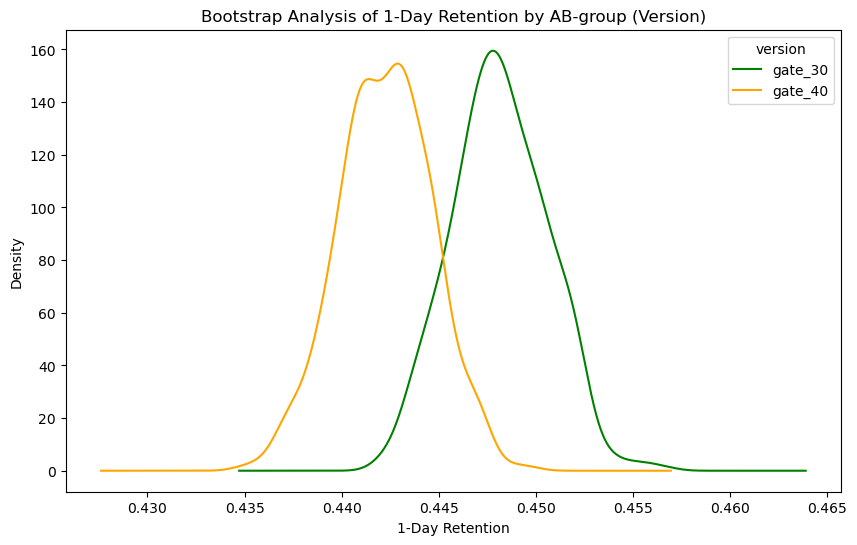

In [28]:
# Creating an list with bootstrapped means for each AB-group
boot_1d=[]
n_replications= 500
for i in range (n_replications):
    boot_mean= Cookiecat_df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
#Plot boot_1d as a Kernel Density Plot
ax= boot_1d.plot(kind= 'kde', figsize =(10,6), color=['Green','Orange'])
ax.set_xlabel("1-Day Retention")
ax.set_ylabel("Density")
ax.set_title("Bootstrap Analysis of 1-Day Retention by AB-group (Version)")

## Zooming in on the difference
For the two AB-groups, these two distributions above show the bootstrap uncertainty of the underlying 1-day retention. Simply by skimming this figure, we can tell that there seems to be some, if little, evidence of a difference. Focusing on the variation in 1-day retention


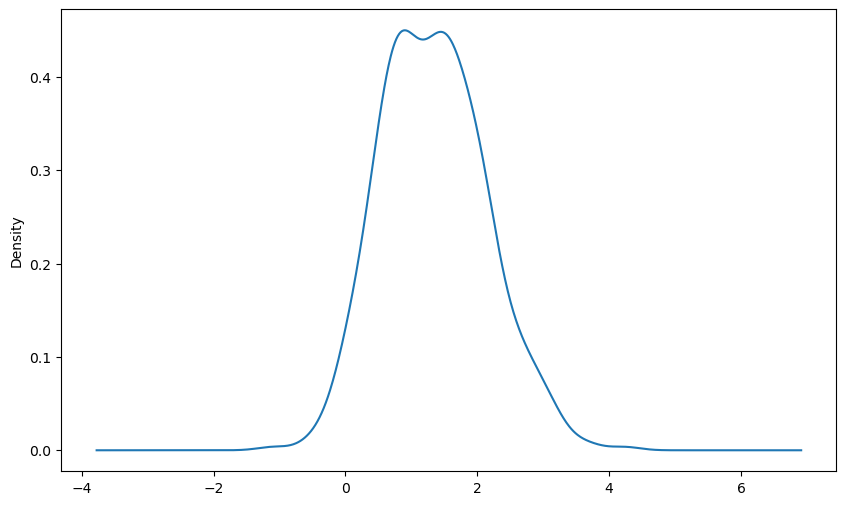

In [29]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff']= ((boot_1d['gate_30']-boot_1d['gate_40'])/boot_1d['gate_40']*100)
#Plot the bootstrap % difference
ax= boot_1d['diff'].plot(kind='kde', figsize=(10,6))
ax.set_xlable= (' % difference between the two AB-groups')
ax.set_ylable= ('Destity')
ax.set_title= ('Bootstrap difference analysis in 1-day retention for the two AB-groups')
           

## The probability of a difference
According to this graph, the most probable percent difference is between 1% and 2%, and the majority of the distribution is above 0%, favouring a gate at level 30. However, what is the likelihood that the difference is more than 0%? Let's figure it out as well.

In [30]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob = (boot_1d['diff']>0).mean()

# Pretty printing the probability
print(prob*100)

97.2


## 7-day retention by AB-group
According to the bootstrap analysis, there is a good chance that a level 30 gate will result in greater 1-day retention. The majority of players probably haven't reached level 30 yet, given that players have only been playing the game for one day. That is, even if the gate appears at level 30, many players won't have been impacted by it.

However, more players ought to have attained level 40 after a week of play, therefore it makes reasonable to additionally include 7-day retention. That is, what proportion of those who downloaded the game returned a week later to play it again.

First, let's determine the 7-day retention for the two AB-groups.


In [31]:
# Calculating 7-day retention for both AB-groups
Cookiecat_df['retention_7']=Cookiecat_df.groupby('version')['retention_7'].mean()

## Bootstrapping the difference again
Similar to the 1-day retention, we see that the 7-day retention is somewhat lower (18.2%) at level 40 than it is at level 30 (19.0%). Additionally, this disparity is greater than for 1-day retention, most likely as a result of more players having had a chance to enter the first gate. More individuals don't play a game a day after installing it than a week later, as shown by the fact that the overall 7-day retention is lower than the overall 1-day retention.

To determine how confident we should be about the difference between the AB-groups, let's apply bootstrap analysis as previously.


C:\Users\Admin\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\hist.py:203: RuntimeWarning: All-NaN slice encountered
  sample_range = np.nanmax(y) - np.nanmin(y)
C:\Users\Admin\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\hist.py:205: RuntimeWarning: All-NaN slice encountered
  np.nanmin(y) - 0.5 * sample_range,
C:\Users\Admin\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\hist.py:206: RuntimeWarning: All-NaN slice encountered
  np.nanmax(y) + 0.5 * sample_range,


ValueError: `dataset` input should have multiple elements.

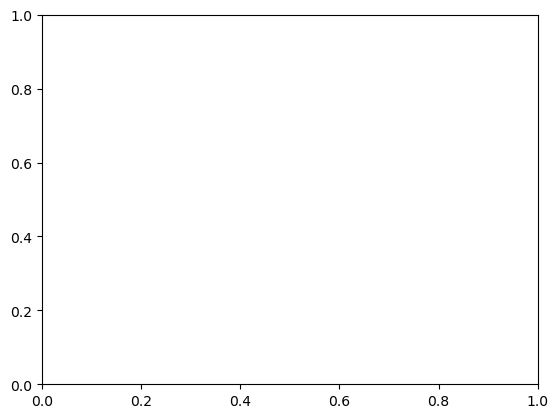

In [34]:
# Creating a list with bootstrapped means for each AB-group
boot_7d = []
for i in range(500):
    boot_mean = Cookiecat_df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_7d = pd.DataFrame(boot_7d)

# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = (boot_7d['gate_30'] - boot_7d['gate_40']) /  boot_7d['gate_30'] * 100

# Ploting the bootstrap % difference
ax = boot_7d['diff'].plot(kind = 'kde')
ax.set_xlabel("% difference in means")

# Calculating the probability that 7-day retention is greater when the gate is at level 30
prob = (boot_7d['diff'] > 0).sum() / len(boot_7d)

# Pretty printing the probability
'{:.1%}'.format(prob)

# Conclusion
According to the bootstrap finding, there is convincing evidence that when the gate is at level 30 as opposed to level 40, 7-day retention is greater. The conclusion is that we shouldn't change the gate from level 30 to level 40 if we want to maintain good retention—both 1-day and 7-day retention. Of course, there are further metrics we might examine, such as the quantity of game rounds played or the amount of in-game purchases made by the two AB-groups. However, one of the most crucial measures is retention. It doesn't matter how much money players spend in-game if we can't keep them as customers.


Why, therefore, does retention increase when the gate is placed earlier? The reverse may be anticipated: The longer people play the game, the later the hurdle will be. But the evidence do not support this. One reason for this is the hedonic adaptation idea. Hedonic adaptation, to put it briefly, is the propensity for humans to derive less and less pleasure over time from an enjoyable activity if that action is continued. Players' pleasure in the game is increased by making them stop when they get to a gate. However, fewer players reach level 40 when the gate is relocated there, and those who do are more likely to abandon the game out of boredom.
